#Майнор ИАД. Домашнее задание 3. YOLO.

В этом задании вы напишете и обучите свой собственный YOLO детектор. Нужно будет разобраться со статьей: понять какого формата должна быть обучающая пара (x, y), как перевести лосс из математической формулы в питоновский код - ну и конечно понять и реализовать саму архитектуру модели.

Выборка на котрой мы будем обучать модель состоит из разнообразных фотографий яблок, бананов и апельсинов. Данные скачиваем [отсюда](https://drive.google.com/file/d/1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3/view?usp=sharing).

Баллы за ДЗ распределены следующим образом: 
- Выборка для YoloV1 - 2 балла
- YOLO модель - 2 балла
- YOLO Loss - 3 балла
- Вспомогательные функции - 2 балла
- Обучение и расчет метрик - 2 балла

Для построения и обучения можно использовать как pytorch, так и pytorch-lightning.

Да-да, баллов в сумме получается 11

In [1]:
 !pip install wandb
 !pip3 install pytorch_lightning torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 14.5 MB/s 
     |████████████████████████████████| 182 kB 68.4 MB/s 
     |████████████████████████████████| 173 kB 71.8 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 168 kB 77.7 MB/s 
     |████████████████████████████████| 168 kB 79.4 MB/s 
     |████████████████████████████████| 166 kB 79.2 MB/s 
     |████████████████████████████████| 166 kB 77.3 MB/s 
     |████████████████████████████████| 162 kB 77.7 MB/s 
     |████████████████████████████████| 162 kB 81.2 MB/s 
     |████████████████████████████████| 158 kB 82.6 MB/s 
     |████████████████████████████████| 157 kB 80.0 MB/s 
     |████████████████████████████████| 157 kB 79.3 MB/s 
     |████████████████████████████████| 157 kB 81.9 MB/s 
     |████████████████████████████████| 157 kB 71.6 MB/s 
     |███████████████████████████

In [2]:
# Данная библиотека понадобится нам, чтобы обработать разметку
! pip install xmltodict pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Скачаем данные

In [3]:
!wget --quiet --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3" -O data.zip && rm -rf /tmp/cookies.txt
!unzip -q data.zip
!rm data.zip
!ls -l

total 12
drwx------ 4 root root 4096 Nov 26 08:32 data
drwxr-xr-x 3 root root 4096 Dec 17 16:14 __MACOSX
drwxr-xr-x 1 root root 4096 Dec 16 00:01 sample_data


Посмотрим как выглядит один из файлов разметки

In [4]:
!cat data/train/apple_3.xml

<annotation>
	<folder>train</folder>
	<filename>apple_3.jpg</filename>
	<path>C:\tensorflow1\models\research\object_detection\images\train\apple_3.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1000</width>
		<height>708</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>584</xmin>
			<ymin>438</ymin>
			<xmax>867</xmax>
			<ymax>708</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>492</xmin>
			<ymin>141</ymin>
			<xmax>740</xmax>
			<ymax>394</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>176</xmin>
			<ymin>199</ymin>
			<xmax>490</xmax>
			<ymax>466</ymax>
		</bndbox>
	</object>
	<obj

## Релизуйте выборку для YoloV1 - 2 балла

In [5]:
import os
import cv2
import json
import glob
import tqdm
import xmltodict

from IPython.core.display import struct

from typing import List

import pandas as pd
import numpy as np

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

import albumentations as A
import albumentations.pytorch

from PIL import Image

import matplotlib.pyplot as plt

from sklearn.metrics import auc
# Добавьте необходимые вам библиотеки, если их не окажется в списке выше
import xml.etree.ElementTree as ET
from collections import Counter
from IPython.display import clear_output
import random

In [6]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

Так как в этом домашнем задании использовать аугментации для обучения __обязательно__ - советуем воспользоваться библиотекой albumentations.

Она  особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Для знакомства с этим механизмом советуем следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). 

Вы все еще можете избрать путь torchvision.transforms, вам потребуется знакомый нам метод `__getitem__`, однако вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную

__Обратите внимание__ на то, что в статье коробки предсказаний параметризуются через: _(x_center, y_center, width, height)_ (причем эти значения _относительные_), а в наших файлах - это _(x_min, y_min, x_max, y_max)_

Также, помните что модель должна предсказывать как прямоугольник с обьектом, так и вероятности каждого класса!

In [7]:
#я в своем решении опиралась на туториал по yolov1 из интернета (https://www.youtube.com/watch?v=n9_XyCGr-MI&ab_channel=AladdinPersson)
#и на еще один туториал по yolov1 (https://www.kaggle.com/code/vexxingbanana/yolov1-from-scratch-pytorch),
#поэтому что-то может быть взято оттуда

In [8]:
from albumentations.augmentations.geometric.functional import bbox_piecewise_affine
class2tag = {"apple": 1, "orange": 2, "banana": 3}

class FruitDataset(Dataset):
    def __init__(self, data_dir, transforms=None, S=7, B=2, C=3):
        self.image_paths = sorted(glob.glob(os.path.join(data_dir, "*.jpg")))  ## YOUR CODE
        self.box_paths = sorted(glob.glob(os.path.join(data_dir, "*.xml"))) ## YOUR CODE

        assert len(self.image_paths) == len(self.box_paths)

        self.transforms = transforms
        self.S = S
        self.B = B
        self.C = C

    # Координаты прямоугольников советуем вернуть именно в формате (x_center, y_center, width, height)
    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        boxes, class_labels = self.__get_boxes_from_xml(self.box_paths[idx], self.image_paths[idx])
        
        if self.transforms:
        ## YOUR CODE
          augmentations = self.transforms(image=image, bboxes=boxes, class_labels=class_labels)
          image = augmentations["image"]
          boxes = augmentations["bboxes"]
          class_labels = augmentations["class_labels"]

        target_tensor = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for label, box in zip(class_labels, boxes):
          label = int(label)
          i, j = int(self.S * box[1]), int(self.S * box[0])
          x_cell, y_cell = self.S * box[0] - j, self.S * box[1] - i
          width_cell, height_cell = box[2] * self.S, box[3] * self.S

          if target_tensor[i, j, self.C] == 0:
                target_tensor[i, j, self.C] = 1
                box_coordinates = torch.tensor([x_cell, y_cell, width_cell, height_cell])
                target_tensor[i, j, 4:8] = box_coordinates
                target_tensor[i, j, label] = 1
        image = image.float()
        return image, target_tensor

    def __len__(self):
      return len(self.image_paths)

    def __get_boxes_from_xml(self, xml_filename: str, img_filename: str):
      """
      Метод, который считает и распарсит (с помощью xmltodict) переданный xml
      файл и вернет координаты прямоугольников обьектов на соответсвующей фотографии
      и название класса обьекта в каждом прямоугольнике

      Обратите внимание, что обьектов может быть как несколько, так и один единственный
      """
      #парсим xml-файл
      mytree = ET.parse(xml_filename)
      myroot = mytree.getroot()
      mydict = xmltodict.parse(ET.tostring(myroot).decode())
      #считываем размер картинки
      img = Image.open(img_filename)
      width, height = img.size

      boxes = []
      class_labels = []

      ## YOUR CODE
      if type(mydict['annotation']['object']) == list:
        for obj in mydict['annotation']['object']:
          boxes.append(self.__convert_to_yolo_box_params(list(map(lambda x: int(x), list(obj['bndbox'].values()))), width, height))
          class_labels.append(class2tag[obj['name']])
      else:
          boxes.append(self.__convert_to_yolo_box_params(list(map(lambda x: int(x), list(mydict['annotation']['object']['bndbox'].values()))), width, height))
          class_labels.append(class2tag[mydict['annotation']['object']['name']])
      ## YOUR CODE
      
      return boxes, class_labels

    def __convert_to_yolo_box_params(self, box_coordinates: List[int], im_w, im_h):
      """
      Перейти от [xmin, ymin, xmax, ymax] к [x_center, y_center, width, height].
      
      Обратите внимание, что параметры [x_center, y_center, width, height] - это
      относительные значение в отрезке [0, 1]

      :param: box_coordinates - координаты коробки в формате [xmin, ymin, xmax, ymax]
      :param: im_w - ширина исходного изображения
      :param: im_h - высота исходного изображения

      :return: координаты коробки в формате [x_center, y_center, width, height]
      """
      ans = []

      ans.append(((box_coordinates[0] + box_coordinates[2]) / 2) / im_w)  # x_center
      ans.append(((box_coordinates[1] + box_coordinates[3]) / 2) / im_h)  # y_center
      
      ans.append((box_coordinates[2] - box_coordinates[0]) / im_w)  # width
      ans.append((box_coordinates[3] - box_coordinates[1]) / im_h)  # height
      return ans

In [9]:
WIDTH = 448
HEIGHT = 448

train_transform = A.Compose([A.Resize(height=HEIGHT, width=WIDTH), A.pytorch.transforms.ToTensorV2()], ## YOUR CODE
                             bbox_params=A.BboxParams(format='yolo',
                                                      label_fields=['class_labels']))
test_transform = A.Compose([A.Resize(height=HEIGHT, width=WIDTH), A.pytorch.transforms.ToTensorV2()], ## YOUR CODE
                            bbox_params=A.BboxParams(format='yolo',
                                                     label_fields=['class_labels']))

In [10]:
train_dataset = FruitDataset(
    transforms=train_transform,
    data_dir="./data/train"
    )

val_dataset = FruitDataset(
    transforms=test_transform, 
    data_dir="./data/test"
    )

# Немного проверок, чтобы убедиться в правильности направления решения
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[0][0], torch.Tensor)
print("Тесты успешно пройдены")

Тесты успешно пройдены


In [11]:
set_random_seed(123)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size= 4,
    shuffle=True)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size= 4, 
    shuffle=False
    )

Теперь определим функцию для рассчета Intersection Over Union по 4 углам двух прямоугольников

In [12]:
def intersection_over_union(boxes_preds, boxes_labels):
    
    box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
    box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
    box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
    box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
    box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
    box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
    box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
    box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
    
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)
    
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    
    return intersection / (box1_area + box2_area - intersection + 1e-6)

Теперь начинается основная часть домашнего задания: обучите модель YOLO для object detection на __обучающем__ датасете. 

 - Создайте модель и функцию ошибки YoloV1 прочитав [оригинальную статью](https://paperswithcode.com/paper/you-only-look-once-unified-real-time-object)
 - Напишите функцию обучения модели
 - Используйте аугментации

## Реализуйте Модель - 2 балла

Копировать точное количество слоев и параметры сверток необязательно. Главное - чтобы модель работала по принципу, описанному в статье и делала предсказание в представленном формате.


В качестве подсказки напомним, что выходом модели __для каждого обьекта__ должен быть тензор размера
__S * S * (B * 5 + С)__, где все параметры имеют такое же значение, как и в статье: 

- S - количество ячеек на которое разбивается изображение по вертикали/горизонтали
- В - количество предсказываемых прямоугольников в каждой ячейке
- 5 - количество параметров для определения каждого прямоугольника (x_center, y_center, width, height, confidence)
- С - количество классов (apple, banana, orange)

Таким образом, мы для каждого окна размера __S x S__ предсказываем __В__ коробо и один класс

In [13]:
class CNNBlock(nn.Module):  # можно поменять на Lightning
    def __init__(self, in_channels, out_channels, is_max_pool:bool=False, **kwargs):
        
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)  # в статье еще не знали про батчнорм, но мы то из будущего ...
        self.leakyrelu = nn.LeakyReLU(0.1)

        self.is_maxpool = is_max_pool  # не после каждой свертки нужно делать maxpool
        self.maxpool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.leakyrelu(self.batchnorm(self.conv(x)))

        if self.is_maxpool:
            x = self.maxpool(x)

        return x
    
class YOLO(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super(YOLO, self).__init__()

        self.S = S
        self.B = B
        self.C = C

        ## YOUR CODE
        self.darknet = self.conv_layers()
        self.fcs = self.fc_layers()
        ## YOUR CODE

    def forward(self, x):
        ## YOUR CODE
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def conv_layers(self):
        layers = [
            CNNBlock(in_channels=3, out_channels=64, is_max_pool=True, kernel_size=7, stride=2, padding=3),

            CNNBlock(in_channels=64, out_channels=192, is_max_pool=True, kernel_size=3, stride=1, padding=1),

            CNNBlock(in_channels=192, out_channels=128, kernel_size=1, stride=1, padding=0),
            CNNBlock(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            CNNBlock(in_channels=256, out_channels=256, kernel_size=1, stride=1, padding=0),
            CNNBlock(in_channels=256, out_channels=512, is_max_pool=True, kernel_size=3, stride=1, padding=1)
            ]
        layers += [
            CNNBlock(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0),
            CNNBlock(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        ]*4
        layers += [
            CNNBlock(in_channels=512, out_channels=512, kernel_size=1, stride=1, padding=0),
            CNNBlock(in_channels=512, out_channels=1024, is_max_pool=True, kernel_size=3, stride=1, padding=1),

            CNNBlock(in_channels=1024, out_channels=512, kernel_size=1, stride=1, padding=0),
            CNNBlock(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
            CNNBlock(in_channels=1024, out_channels=512, kernel_size=1, stride=1, padding=0),
            CNNBlock(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
            CNNBlock(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
            CNNBlock(in_channels=1024, out_channels=1024, kernel_size=3, stride=2, padding=1),

            CNNBlock(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
            CNNBlock(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1)
        ]

        return nn.Sequential(*layers)

    def fc_layers(self):
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * self.S * self.S, 4096),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, self.S * self.S * (self.C + self.B * 5))
        )




temp_model = YOLO()
expected_output_shape = temp_model.S * temp_model.S * (5 * temp_model.B + temp_model.C)

assert temp_model(torch.unsqueeze(train_dataset[0][0], 0)).reshape(-1).shape[0] == train_dataset[0][1].reshape(-1).shape[0]
assert temp_model(torch.unsqueeze(train_dataset[0][0], 0)).reshape(-1).shape[0] == expected_output_shape

## Реализуйте YoloLoss - 3 балла

In [14]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super().__init__()
        self.mse = nn.MSELoss(reduction="sum")

        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        ## YOUR CODE
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        iou_b1 = intersection_over_union(predictions[..., self.C + 1:self.C + 5], target[..., self.C + 1:self.C + 5])
        iou_b2 = intersection_over_union(predictions[..., self.C + 6:self.C + 10], target[..., self.C + 1:self.C + 5])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., self.C].unsqueeze(3)

        box_predictions = exists_box * (
            (
                bestbox * predictions[..., self.C + 6:self.C + 10]
                + (1 - bestbox) * predictions[..., self.C + 1:self.C + 5]
            )
        )

        box_targets = exists_box * target[..., self.C + 1:self.C + 5]

        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )
        
        pred_box = (
            bestbox * predictions[..., self.C + 5:self.C + 6] + (1 - bestbox) * predictions[..., self.C:self.C + 1]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., self.C:self.C + 1]),
        )

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C:self.C + 1], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:self.C + 1], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C + 5:self.C + 6], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:self.C + 1], start_dim=1)
        )

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :self.C], end_dim=-2,),
            torch.flatten(exists_box * target[..., :self.C], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss
            + object_loss
            + self.lambda_noobj * no_object_loss
            + class_loss
        )

        return loss

## Реализуйте дополнительные функции из статьи - 2 балла

In [15]:
device = torch.device("cuda")

def non_max_suppression(bboxes, iou_threshold, threshold):
    ## YOUR CODE
    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5):
    ## YOUR CODE
    average_precisions = []
    epsilon = 1e-6

    for c in range(3):
        detections = []
        ground_truths = []
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

def get_bound_boxes(loader, model, iou_threshold=.5, threshold=.4):
    ## YOUR CODE
    all_pred_boxes = []
    all_true_boxes = []

    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()

    return all_pred_boxes, all_true_boxes

def convert_cellboxes(predictions, S=7, C=3):
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, C + 10)
    bboxes1 = predictions[..., C + 1:C + 5]
    bboxes2 = predictions[..., C + 6:C + 10]
    scores = torch.cat(
        (predictions[..., C].unsqueeze(0), predictions[..., C + 5].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., C + 5]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

## Обучите модель и посчитайте метрики для задачи детекции - 2 балла 

Несмотря на то, что в этом блоке ничего сильно нового для вас не ожидается и за него формально дается лишь два балла - провести обучение очень важно для понимания того, насколько правильно реализована ваша модель и лосс.

В процессе обучения будет видно все ли размерности совпадают, падает ли лосс и растут ли метрики целевой задачи, поэтому на практике этот пункт гораздо оказывается гораздо важнее.

In [16]:
from tqdm.notebook import tqdm

def train(model, optimizer, criterion, train_loader, test_loader, n_epoches):
  set_random_seed(123)
  loss1 = [] #массив для ошибок на трейне
  loss2 = [] #массив для ошибок на тесте
  map1 = [] #массив для точности на трейне
  map2 = [] #массив для точности на тесте
  for epoch in range(n_epoches):
    train_loss = []  
    for (x, y) in tqdm(train_loader):    
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred, y)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Train mean loss {np.mean(train_loss)}")

    pred_boxes, target_boxes = get_bound_boxes(train_loader, model, iou_threshold=0.5, threshold=0.4)
    train_map = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5)
    print(f"Train mAP: {train_map}")         

    #считаем ошибку на тесте
    test_loss = []                                
    for (x, y) in tqdm(test_loader):            
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred, y)
        test_loss.append(loss.item())
    print(f"Test mean loss {np.mean(test_loss)}")

    pred_boxes, target_boxes = get_bound_boxes(test_loader, model, iou_threshold=0.5, threshold=0.4)
    test_map = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5)
    print(f"Test mAP: {test_map}")
    
    #рисуем график    
    clear_output(True)
    loss1.append(np.mean(train_loss))
    loss2.append(np.mean(test_loss))
    map1.append(train_map)
    map2.append(test_map)
    fig = plt.figure(figsize=(18,6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    ax1.plot(np.arange(0, len(loss1)), loss1, color = 'b', label = 'train loss')
    ax1.plot(np.arange(0, len(loss2)), loss2, color = 'r', label = 'test loss')
    ax2.plot(np.arange(0, len(map1)), map1, color = 'c', label = 'train mAP')
    ax2.plot(np.arange(0, len(map2)), map2, color = 'y', label = 'test mAP')
    ax1.legend()
    ax1.grid()
    ax1.set_title("Loss")
    ax2.set_title("mAP")
    ax2.legend()
    ax2.grid()
    plt.show()

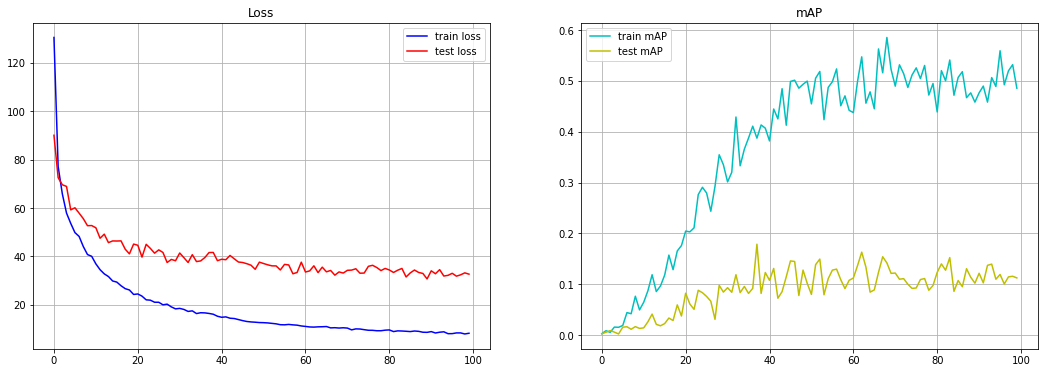

In [17]:
model = YOLO().to(device)
criterion = YoloLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

train(model, optimizer, criterion, train_dataloader, val_dataloader, 100)

In [18]:
checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
}
torch.save(checkpoint, "my_checkpoint.pth")

## Посчитайте метрики задачи детекции на валидационной выборке

Попробуйте понять насколько хороши ваши показатели. Если числа кажутся подозрительно низкими - возможно вам стоит перепроверить ваше решение. 

In [19]:
## YOUR CODE
model.load_state_dict(torch.load("my_checkpoint.pth")["state_dict"])
optimizer.load_state_dict(torch.load("my_checkpoint.pth")["optimizer"])

test_loss = []                                
for (x, y) in tqdm(val_dataloader):            
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    test_loss.append(loss.item())
print(f"Test mean loss {np.mean(test_loss)}")

pred_boxes, target_boxes = get_bound_boxes(val_dataloader, model, iou_threshold=0.5, threshold=0.4)
test_map = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5)
print(f"Test mAP: {test_map}")

  0%|          | 0/15 [00:00<?, ?it/s]

Test mean loss 32.21213715871175
Test mAP: 0.09911220520734787


## Визуализируйте предсказанные bounding box'ы для любых пяти картинок из __валидационного__ датасета.

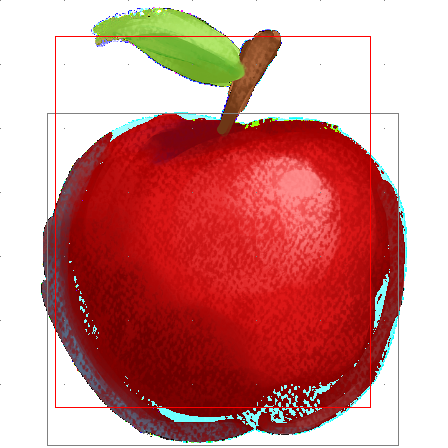

In [20]:
from PIL import ImageDraw, ImageOps

def draw_image(index):
  model.load_state_dict(torch.load("my_checkpoint.pth")["state_dict"])
  optimizer.load_state_dict(torch.load("my_checkpoint.pth")["optimizer"])
  
  image, targets = val_dataset[index]
  preds = model(torch.unsqueeze(image.to(device), 0)) ## YOUR CODE
  preds = cellboxes_to_boxes(preds)[0]
  preds = non_max_suppression(preds, iou_threshold=0.5, threshold=0.4)
  image = torchvision.transforms.ToPILImage()(image)
  image = ImageOps.invert(image)
  draw = ImageDraw.Draw(image)
  pred_boxes, target_boxes = get_bound_boxes(val_dataloader, model, iou_threshold=0.5, threshold=0.4)
  width, height = image.size

  for i in range(len(targets)):
    ## YOUR CODE
      for j in range(len(targets[i])):
        x_cell, y_cell, width_cell, height_cell = targets[i, j, 4:8]
        x1 = x_cell*width/7 - (width_cell/2*width/7) + width/7*j
        x2 = x_cell*width/7 + (width_cell/2*width/7) + width/7*j
        y1 = y_cell*height/7 - (height_cell/2*height/7) + height/7*i
        y2 = y_cell*height/7 + (height_cell/2*height/7) + height/7*i
        draw.rectangle([(x1, y1), (x2, y2)], outline='grey')

  for box in preds:
    ## YOUR CODE
      box = box[2:]
      upper_left_x = box[0] - box[2] / 2
      upper_left_y = box[1] - box[3] / 2
      draw.rectangle([(upper_left_x * width, upper_left_y * height), ((upper_left_x + box[2]) * width, (upper_left_y + box[3]) * height)], outline='red')
  return image

image = draw_image(2)
image

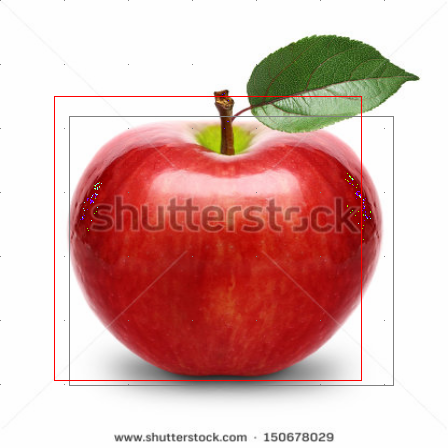

In [21]:
image = draw_image(5)
image

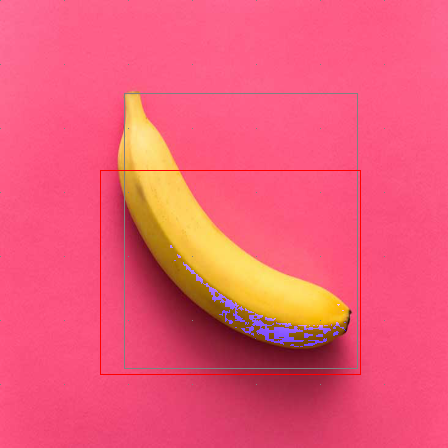

In [22]:
image = draw_image(30)
image

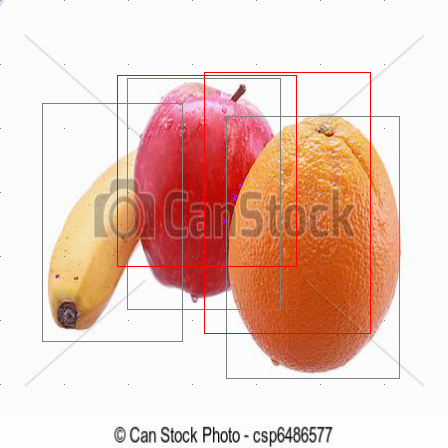

In [25]:
image = draw_image(41)
image

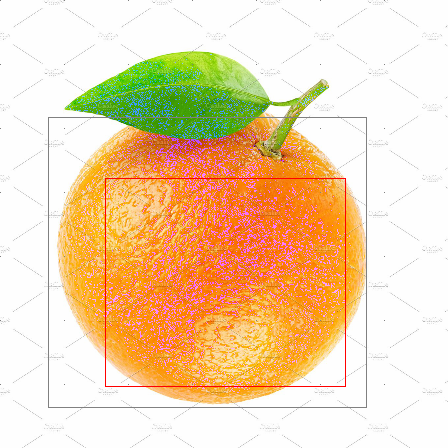

In [28]:
image = draw_image(59)
image